[0.00000000e+00 2.05364395e-01 1.66654521e-01 2.61925389e-01
 3.83043207e-01 5.36449733e-01 6.43512393e-01 7.08795974e-01
 7.71388802e-01 8.31518102e-01 8.89370159e-01 9.45101295e-01
 9.98845157e-01 1.05071776e+00 1.10082111e+00 1.14924583e+00
 1.19607319e+00 1.26272266e+00 1.34773945e+00 1.42748064e+00
 1.50233927e+00 1.57265681e+00 1.63873391e+00 1.70083811e+00
 1.75920964e+00 1.81406582e+00 1.86560457e+00 1.91400709e+00
 1.96999066e+00 2.03194171e+00 2.09653827e+00 2.15467569e+00
 2.19887415e+00 2.24446404e+00 2.29486547e+00 2.34128870e+00
 2.37831850e+00 2.40694069e+00 2.42802857e+00 2.44235960e+00
 2.45200669e+00 2.44827880e+00 2.42789160e+00 2.39418835e+00
 2.34991916e+00 2.29735733e+00 2.23838836e+00 2.17457937e+00
 2.10723418e+00 2.03743761e+00 1.96609131e+00 1.87621737e+00
 1.76792415e+00 1.66105743e+00 1.55677074e+00 1.43994159e+00
 1.31263188e+00 1.19329552e+00 1.08228487e+00 9.79649938e-01
 8.85231487e-01 7.98729361e-01 7.01865071e-01 5.98919386e-01
 4.97203699e-01 4.106595

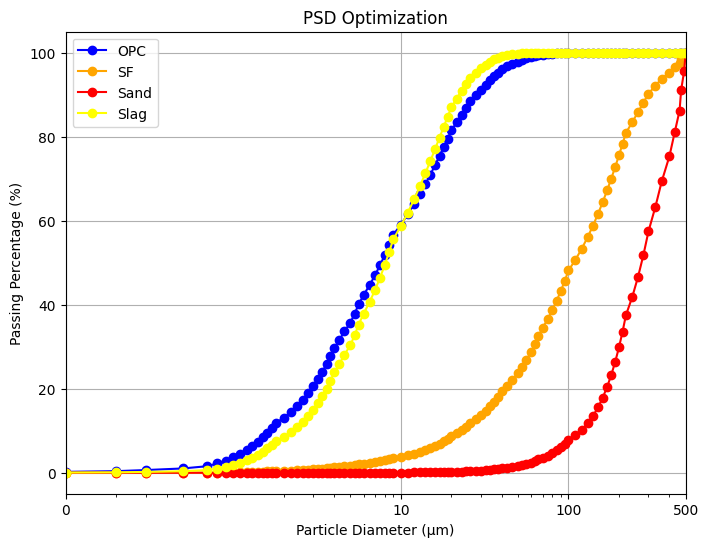

Method: L-BFGS-B
Optimal weights (with Weight_OPC fixed at 1.0):
Weight_OPC = 1.000
Weight_SF = 0.200
Weight_SS = 1.000
Weight_Slag = 0.499
Minimum RMSE = 5.813
MAE = 5.133
Method: TNC
Optimal weights (with Weight_OPC fixed at 1.0):
Weight_OPC = 1.000
Weight_SF = 0.200
Weight_SS = 1.000
Weight_Slag = 0.499
Minimum RMSE = 5.813
MAE = 5.133
Method: SLSQP
Optimal weights (with Weight_OPC fixed at 1.0):
Weight_OPC = 1.000
Weight_SF = 0.200
Weight_SS = 1.000
Weight_Slag = 0.499
Minimum RMSE = 5.813
MAE = 5.133


In [7]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Full path to your Excel file
excel_file = r"UHPC.xlsx"
df = pd.read_excel(excel_file, sheet_name='Sheet2')

# Extract columns from the DataFrame
A = df['Cement'].values
B = df['Silica Fume'].values
C = df['Sand'].values
D = df['Slag'].values
print(A)
print(np.cumsum(A))
d = df['Particle diameter'].values

plt.figure(figsize=(8, 6))
d_plot = d[1:]  # Exclude the first element from x-axis values
print(d_plot)
plt.plot(d_plot, np.cumsum(A[1:]), label=f'OPC', color='blue', marker='o')
plt.plot(d_plot, np.cumsum(B[1:]), label=f'SF', color='orange', marker='o')
plt.plot(d_plot, np.cumsum(C[1:]), label=f'Sand', color='red', marker='o')
plt.plot(d_plot, np.cumsum(D[1:]), label=f'Slag', color='yellow', marker='o')
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('Particle Diameter (μm)')
plt.ylabel('Passing Percentage (%)')
plt.title('PSD Optimization')


plt.xlim(left=d_plot.min(), right=500)
formatter = FuncFormatter(lambda x, _: f'{x:.0f}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.xticks([d_plot.min(), 10, 100, 500])

plt.legend()
plt.grid(True)  # Show grid for both major and minor ticks

plt.show()

def optimal_psd_function(d, q, min_d, max_d):
    d = np.array(d)
    alpha = (((d**q) - (min_d**q)) / ((max_d**q) - (min_d**q))) * 100
    return alpha

d = df['Particle diameter']
q = 0.25
min_d = 0.1
max_d = 500

alpha = optimal_psd_function(d, q, min_d, max_d)

# Define densities for the components (g/cm^3)
Density_OPC = 3.15
Density_SF = 2.2
Density_SS = 2.6
Density_Slag = 2.85

# Fixed value for Weight_OPC
Weight_OPC = 1.0



# Define the RMSE function to minimize
def rmse_function(weights):

    Weight_SF, Weight_SS, Weight_Slag = weights
    Total_Volume = (Weight_OPC / Density_OPC 
                    + Weight_SF / Density_SF 
                    + Weight_SS / Density_SS 
                    + Weight_Slag / Density_Slag)
    
    # Calculate Binder based on the provided formula
    Binder = (A * Weight_OPC / (Total_Volume * Density_OPC)
              + B * Weight_SF / (Total_Volume * Density_SF)
              + C * Weight_SS / (Total_Volume * Density_SS)
              + D * Weight_Slag / (Total_Volume * Density_Slag))
    
    # Create a cumulative column based on Binder
    cumulative = np.cumsum(Binder)

    # Save cumulative to be used for MAE calculation
    rmse_function.cumulative = cumulative
    rmse = np.sqrt(np.mean((alpha[1:100] - cumulative[1:100])**2))
    return rmse

# Initial guess for the weights [Weight_SF, Weight_SS, Weight_Slag]
initial_guess = [0.1, 1, 1.0 / 10]  # An initial guess within the acceptable range for Weight_Slag

# Function to dynamically set bounds for weights
def get_bounds():
    return [(0, 0.2), (1, None), (0, None)]

# List of optimization methods that support bounds
methods = ['L-BFGS-B', 'TNC', 'SLSQP']

for method in methods:
    bounds = get_bounds()
    result = minimize(rmse_function, initial_guess, bounds=bounds, method=method)
    
    # Extract the optimal weights
    optimal_weights = result.x
    
    # Calculate the cumulative Binder values for the optimal weights
    cumulative = rmse_function.cumulative

    # Calculate MAE
    mae = np.mean(np.abs(alpha[1:100] - cumulative[1:100]))
    
    # Print the method used, optimal weights, minimum RMSE, and MAE
    print(f"Method: {method}")
    print("Optimal weights (with Weight_OPC fixed at 1.0):")
    print("Weight_OPC = {:.3f}".format(Weight_OPC))
    print("Weight_SF = {:.3f}".format(optimal_weights[0]))
    print("Weight_SS = {:.3f}".format(optimal_weights[1]))
    print("Weight_Slag = {:.3f}".format(optimal_weights[2]))
    print("Minimum RMSE = {:.3f}".format(result.fun))
    print("MAE = {:.3f}".format(mae))


[0.00000000e+00 4.00872899e-02 5.14199416e-02 9.67593432e-02
 1.66734455e-01 2.70747415e-01 3.52953988e-01 4.07212050e-01
 4.61932959e-01 5.16970376e-01 5.72200997e-01 6.27519374e-01
 6.82834243e-01 7.38065835e-01 7.93143873e-01 8.48006029e-01
 9.02596720e-01 9.83108279e-01 1.09016181e+00 1.19536881e+00
 1.29849078e+00 1.39933086e+00 1.49772646e+00 1.59354372e+00
 1.68667307e+00 1.77702578e+00 1.86453112e+00 1.94913401e+00
 2.05019021e+00 2.16602343e+00 2.29198501e+00 2.41004318e+00
 2.50342085e+00 2.60350245e+00 2.71930942e+00 2.83200121e+00
 2.92781128e+00 3.00751994e+00 3.07196660e+00 3.12202914e+00
 3.17029192e+00 3.19569593e+00 3.17962712e+00 3.12889798e+00
 3.04983834e+00 2.94821498e+00 2.82919466e+00 2.69733771e+00
 2.55661307e+00 2.41042759e+00 2.26166456e+00 2.07656578e+00
 1.85827295e+00 1.64964059e+00 1.45389583e+00 1.24552457e+00
 1.03254111e+00 8.47969916e-01 6.90504503e-01 5.57951118e-01
 4.47661130e-01 3.56833746e-01 2.67513137e-01 1.86357218e-01
 1.21208394e-01 7.683956

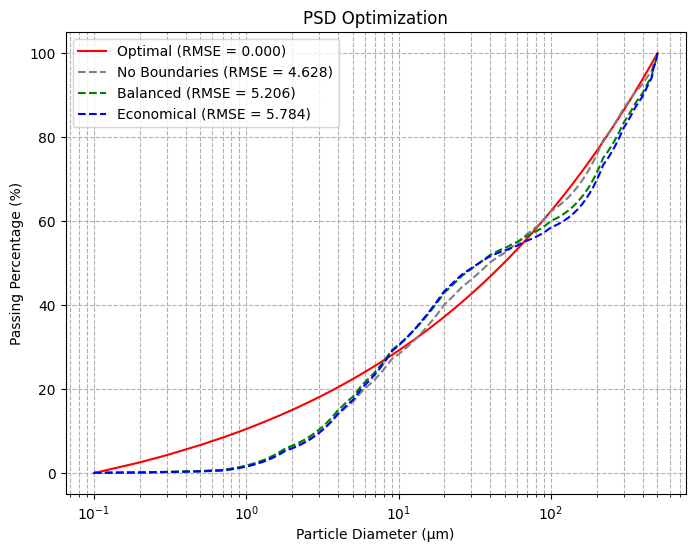

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def create_graph():
    # Full path to your Excel file
    excel_file = r"UHPC.xlsx"
    df = pd.read_excel(excel_file, sheet_name='Sheet2')

    # Extract columns from the DataFrame
    A = df['Cement'].values
    B = df['Silica Fume'].values
    C = df['Sand'].values
    D = df['Slag'].values
    d = df['Particle diameter'].values

    print(D)
    def optimal_psd_function(d, q, min_d, max_d):
        d = np.array(d)
        alpha = (((d**q) - (min_d**q)) / ((max_d**q) - (min_d**q))) * 100
        return alpha

    q = 0.25
    min_d = 0.1
    max_d = 500

    alpha = optimal_psd_function(d, q, min_d, max_d)

    # Define densities for the components (g/cm^3)
    Density_OPC = 3.15
    Density_SF = 2.2
    Density_SS = 2.6
    Density_Slag = 2.85

    # Fixed value for Weight_OPC
    Weight_OPC = 1.0

    # Define the RMSE function to minimize
    def rmse_function(weights):
        Weight_SF, Weight_SS, Weight_Slag = weights
        Total_Volume = (Weight_OPC / Density_OPC 
                        + Weight_SF / Density_SF 
                        + Weight_SS / Density_SS 
                        + Weight_Slag / Density_Slag)
        
        # Calculate Binder based on the provided formula
        Binder = (A * Weight_OPC / (Total_Volume * Density_OPC)
                + B * Weight_SF / (Total_Volume * Density_SF)
                + C * Weight_SS / (Total_Volume * Density_SS)
                + D * Weight_Slag / (Total_Volume * Density_Slag))
        
        # Create a cumulative column based on Binder
        cumulative = np.cumsum(Binder)

        # Save cumulative to be used for MAE calculation
        rmse_function.cumulative = cumulative
        rmse = np.sqrt(np.mean((alpha[1:] - cumulative[1:])**2))
        return rmse

    # Optimization with no boundaries
    initial_guess = [0.1, 1.0, 1.0 / 10]
    bounds_no_boundaries = [(0, None), (0, None), (0, None)]
    result_no_boundaries = minimize(rmse_function, initial_guess, bounds=bounds_no_boundaries, method='L-BFGS-B')
    optimal_weights_no_boundaries = result_no_boundaries.x
    No_Boundaries = rmse_function.cumulative

    # Optimization with specific bounds
    def get_bounds_balanced():
        return [(0, 0.2), (0, None), (0.091, None)]

    result_balanced = minimize(rmse_function, initial_guess, bounds=get_bounds_balanced(), method='L-BFGS-B')
    optimal_weights_balanced = result_balanced.x
    Balanced = rmse_function.cumulative

    def get_bounds_economical():
        return [(0, 0.2), (1, None), (0, None)]

    result_economical = minimize(rmse_function, initial_guess, bounds=get_bounds_economical(), method='L-BFGS-B')
    optimal_weights_economical = result_economical.x
    Economical = rmse_function.cumulative

    # Calculate RMSE values
    def calculate_rmse(true_values, predicted_values):
        return np.sqrt(np.mean((true_values - predicted_values)**2))

    # RMSE calculations
    rmse_no_boundaries = calculate_rmse(alpha[1:], No_Boundaries[1:])
    rmse_balanced = calculate_rmse(alpha[1:], Balanced[1:])
    rmse_economical = calculate_rmse(alpha[1:], Economical[1:])

    # Print RMSE values and optimal weights
    print(f"Optimal weights for No Boundaries:")
    print(f"Weight_OPC = {Weight_OPC:.3f}")
    print(f"Weight_SF = {optimal_weights_no_boundaries[0]:.3f}")
    print(f"Weight_SS = {optimal_weights_no_boundaries[1]:.3f}")
    print(f"Weight_Slag = {optimal_weights_no_boundaries[2]:.3f}")
    print(f"RMSE for No Boundaries: {rmse_no_boundaries:.3f}")

    print(f"\nOptimal weights for Balanced:")
    print(f"Weight_OPC = {Weight_OPC:.3f}")
    print(f"Weight_SF = {optimal_weights_balanced[0]:.3f}")
    print(f"Weight_SS = {optimal_weights_balanced[1]:.3f}")
    print(f"Weight_Slag = {optimal_weights_balanced[2]:.3f}")
    print(f"RMSE for Balanced: {rmse_balanced:.3f}")

    print(f"\nOptimal weights for Economical:")
    print(f"Weight_OPC = {Weight_OPC:.3f}")
    print(f"Weight_SF = {optimal_weights_economical[0]:.3f}")
    print(f"Weight_SS = {optimal_weights_economical[1]:.3f}")
    print(f"Weight_Slag = {optimal_weights_economical[2]:.3f}")
    print(f"RMSE for Economical: {rmse_economical:.3f}")

    # Exclude the first entry for each dataset
    d_plot = d[1:]  # Exclude the first element from x-axis values
    alpha_plot = alpha[1:]  # Exclude the first element from alpha values
    No_Boundaries_plot = No_Boundaries[1:]  # Exclude the first element from No Boundaries values
    Balanced_plot = Balanced[1:]  # Exclude the first element from Balanced values
    Economical_plot = Economical[1:]  # Exclude the first element from Economical values

    # Plotting the results
    plt.figure(figsize=(8, 6))
    print(alpha_plot)
    plt.plot(d_plot, alpha_plot, label=f'Optimal (RMSE = {calculate_rmse(alpha[1:], alpha_plot):.3f})', color='red')
    plt.plot(d_plot, No_Boundaries_plot, label=f'No Boundaries (RMSE = {rmse_no_boundaries:.3f})', color='grey', linestyle='--')
    plt.plot(d_plot, Balanced_plot, label=f'Balanced (RMSE = {rmse_balanced:.3f})', color='green', linestyle='--')
    plt.plot(d_plot, Economical_plot, label=f'Economical (RMSE = {rmse_economical:.3f})', color='blue', linestyle='--')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xlabel('Particle Diameter (μm)')
    plt.ylabel('Passing Percentage (%)')
    plt.title('PSD Optimization')
    plt.legend()
    plt.grid(True, which="both", ls="--")  # Show grid for both major and minor ticks


    # Define
    save_path_pic = r'uhpc.png'

    # Save the plot as a STL file
    plt.savefig(save_path_pic, format='PNG', dpi=300)
    plt.show()
    plt.close()

create_graph()